In [1]:
from os.path import exists
from os import system
import sys
import os
import datetime as DT
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.animation as animation
import logging
import json
from pprint import pprint
from geopy import distance

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [3]:
class TimeManagement:
  def __init__(self, reloadTime, root_path, save_path, colors, export = True):
    if(root_path is None):
      root_path = os.getcwd()
    if(colors is None):
      colors = {"Game": "blue", "Mirror":"green", "Master": "red", "Browser": "orange", "Other":"yellow", "Social":"purple"}
    
    self.root_path = root_path
    self.save_path = save_path
    self.reloadTime = reloadTime
    self.colors = colors
    self.export = export

    return
  
  # Import & Preprocess Data
  # ==================================================================
  def import_and_preprocess(self, fd=None, td=None):
    if self.export:
      self.export_app_data(fd, td) # debug!
    app, process_tags = self.load_files()
    process_tags = self.tagging(app, process_tags)
    app = self.merge_tags(app, process_tags)
    app = self.create_effective_day(app)
    
    self.app = app
  
  def month_import_and_preprocess(self, month):
    today = DT.date.today()
    fd = today.replace(month=month, day=1)
    td = today.replace(month=month+1, day=1) - DT.timedelta(days=1)

    self.import_and_preprocess(fd, td)

  def export_app_data(self, fd, td):
    app_path = self.root_path + "/data/applications.csv"
    if fd is None and td is None:
      system("D:/ManicTime/mtc export ManicTime/Applications " + app_path)
    else:
      system("D:/ManicTime/mtc export ManicTime/Applications " + app_path + " /fd:" + str(fd) + " /td:" + str(td))
    return

  def load_files(self):
    # Application file from ManicTime
    app = pd.read_csv(self.root_path + "/data/applications.csv", delimiter=";")
    app.Start = pd.to_datetime(app.Start)
    app.End = pd.to_datetime(app.End)
    app.Duration = pd.to_timedelta(app.Duration)
    # app["Day"] = app.Start.dt.floor("d")

    # Read in or Create Processed Tags Table
    process_tags_path = self.root_path + "/data/process_tags.csv"
    if (exists(process_tags_path)):
      process_tags = pd.read_csv(process_tags_path, index_col=0)
    else:
      process_tags = pd.DataFrame(columns=["Process", "Tag"])
    return app, process_tags
  
  def tagging(self, app, process_tags):
    # Fill the missing Tags!
    skipped = []
    
    # Go through application table, look for things that are no in the Process Tags list AND are not a Firefox Window or VSC Window 
    no_need = ["Firefox Developer Edition", "Visual Studio Code"]
    for process in app.Process.unique():
      if((not process_tags.Process.isin([process]).any()) and (process not in no_need)):
        tag = input(process + "\nWhat tag is this process (1-Game, 2-Mirror, 3-Master, 4-Other, else-Skip): ")

        if(tag == "1"):
          process_tags.loc[process_tags.shape[0]] = [process, "Game"]
        elif(tag == "2"):
          process_tags.loc[process_tags.shape[0]] = [process, "Mirror"]
        elif(tag == "3"):
          process_tags.loc[process_tags.shape[0]] = [process, "Master"]
        elif(tag == "4"):
          process_tags.loc[process_tags.shape[0]] = [process, "Other"]
        else:
          skipped.append(process)
    
    if(len(skipped) > 0):
      print("Skipped tagging on: ", skipped)
    
    process_tags.sort_values(by=["Tag", "Process"], inplace=True)
    process_tags.reset_index(drop=True, inplace=True)

    # Save any changes done to the Processed Tags Table
    process_tags.to_csv(self.root_path + "/data/process_tags.csv")
    return process_tags
  
  def merge_tags(self, app, process_tags):
    app = pd.merge(app, process_tags, how="left", left_on="Process", right_on="Process")

    # Special Case VSC
    for i, row in app[app.Process == "Visual Studio Code"].iterrows():
      if(any(x in row.Name for x in ["Passenger_Seo", "matar (Workspace)"])):
        app.at[i, "Tag"] = "Master"
      else:
        app.at[i, "Tag"] = "Mirror"
    
    # Special Case Firefox
    for i, row in app[app.Process == "Firefox Developer Edition"].iterrows():
      if(any(x in row.Name for x in ["YouTube", "Reddit", "Twitch", "Netflix", "Prime Video"])):
        app.at[i, "Tag"] = "Social"
      elif(any(x in row.Name for x in ["ChatGPT", "python", "tensorflow", "TensorFlow", "keras", "Zoom", "TU Berlin"])):
        app.at[i, "Tag"] = "Master"
      elif(any(x in row.Name for x in ["Unity", "unity", "c#", "C#"])):
        app.at[i, "Tag"] = "Mirror"
      else:
        #! Sadly there is no other way to determine what task I was actually doing so everything else goes to Browser
        app.at[i, "Tag"] = "Browser"
    
    #? These are all the websites that needed to be stored as "Browser" since I dont know where to assign them to
    # other = app.loc[(app.Process == "Firefox Developer Edition") & (app.Tag == "Browser"), "Name"].unique()
    # pprint(other)
    return app
  
  def create_effective_day(self, app):
    threshold_hour = 7 #7AM

    # Create a new column 'Effective_Day' by shifting dates back for any time before threshold
    app['Effective_Day'] = app['Start'].apply(lambda x: x - DT.timedelta(days=1) if x.hour < threshold_hour else x)
    app['Effective_Day'] = app['Effective_Day'].dt.floor('D')  # Only keep the date part

    return app
  
  # Graph Assembly
  # ==================================================================
  
  def summary(self, td):
    # Week summary
    fig = plt.figure(figsize=(100, 100))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.1, top=0.9, bottom=0.1)

    # Line Chart
    ax = self.line_chart(self.app, td, ax=plt.subplot(gs[0,:]))
    ax.set_title("Today's recap")

    # Pie Charts
    self.pie_chart(self.app, td - DT.timedelta(days=2), plt.subplot(gs[1,0]))
    ax = self.pie_chart(self.app, td - DT.timedelta(days=1), plt.subplot(gs[1,1]))
    self.pie_chart(self.app, td, plt.subplot(gs[1,2]))
    ax.set_title("3day recap")

    # Bar Plot
    week_ago = td - DT.timedelta(days=7)
    ax = self.bar_chart(self.app, week_ago, td, ax=plt.subplot(gs[2,:]))
    ax.set_title("Week recap")

    fig.canvas.manager.set_window_title('Time Management')
    fig.set_size_inches(10, 9, forward=True) # w, h
    
    # plt.tight_layout()
    # fig.tight_layout()
    plt.savefig(self.save_path + "/summary.jpg")
    return
  
  def week_summary(self, td = DT.date.today()):
    # Week summary
    fig = plt.figure(figsize=(100, 100))
    gs = gridspec.GridSpec(7, 2, figure=fig)

    for i in range(7):
      # Line Chart
      date = td - DT.timedelta(days=7-i)
      ax = self.line_chart(self.app, date, ax=plt.subplot(gs[i, 0]))
      ax.sharex = ax
      ax.legend().set_visible(i == 0) 

      # Pie Charts
      ax = self.pie_chart(self.app, date, plt.subplot(gs[i, 1]))

    fig.canvas.manager.set_window_title('Time Management')
    fig.set_size_inches(10, 13, forward=True)
    plt.tight_layout()
    fig.tight_layout()
    plt.savefig(self.save_path + "/week_report.jpg")

  def three_week_summary(self, td):
    rows = 4
    cols = 7
    
    fig = plt.figure(figsize=(100, 100))
    plt.rcParams.update({'font.size': 22})
    gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.1, top=0.9, bottom=0.1)
    # gs = gridspec.GridSpec(rows, cols, figure=fig)

    used_axes = set()

    # Pie Charts
    # ==========
    # monday 2 weeks ago
    fd = td - DT.timedelta(days=td.weekday()+14)

    for i in range(21):
      date = fd + DT.timedelta(days=i)

      # ax = self.line_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
      ax = self.pie_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
      
      weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
      weekday = weekday[date.weekday()]

      if weekday == "Mon" and i/7 == 0:
        ax.legend = True
        # ax.legend(list(self.colors.keys()), loc='center left', bbox_to_anchor=(-0.5, 0.5))
      
      if ax is not None:
        ax.set_title(weekday + " " + str(date))
        used_axes.add((int(i / cols), i % cols))

    # Line Charts
    # ==========
    for i in range(3):  # One line chart per day
      date = td - DT.timedelta(days=2-i)
      ax = self.line_chart(self.app, date, ax=plt.subplot(gs[3, 2 * i:2 * (i + 1)]))  # Allocate equal space
      
      weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
      weekday = weekday[date.weekday()]

      if ax is not None:
        ax.legend().set_visible(i == 0) 
        ax.set_title(weekday + " " + str(date))
        used_axes.update({(3, j) for j in range(2 * i, 2 * (i + 1))})
    
    for row in range(rows):
      for col in range(cols):
        if (row, col) not in used_axes:
          ax = plt.subplot(gs[row, col])
          ax.axis('off')  # Turn off the axis for unused subplots


    fig.canvas.manager.set_window_title('Time Management')
    fig.set_size_inches(50, 25, forward=True) # w, h

    # plt.tight_layout()
    # fig.tight_layout()
    plt.savefig(self.save_path + "/three_week_summary.jpg")
    return

  def month_view(self, month):
    rows = 5
    cols = 7
    
    fig = plt.figure(figsize=(100, 100))
    plt.rcParams.update({'font.size': 22})
    gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.1, top=0.9, bottom=0.1)
    # gs = gridspec.GridSpec(rows, cols, figure=fig)

    used_axes = set()
    fd = DT.date.today().replace(month=month, day=1)
    td = (DT.date.today().replace(month=month+1, day=1) - DT.timedelta(days=1))
    
    days = td.day
    for i, j in enumerate(range(fd.weekday(), days+1)):
      date = fd + DT.timedelta(days=i)

      # ax = self.line_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
      ax = self.pie_chart(self.app, date, ax=plt.subplot(gs[int(j/cols), j%cols]))
      
      weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
      weekday = weekday[date.weekday()]
      
      if ax is not None:
        ax.set_title(weekday + " " + str(date))
        used_axes.add((int(i / cols), i % cols))
    
    for row in range(rows):
      for col in range(cols):
        if (row, col) not in used_axes:
          ax = plt.subplot(gs[row, col])
          ax.axis('off')  # Turn off the axis for unused subplots
    
    fig.canvas.manager.set_window_title('Time Management')
    fig.set_size_inches(50, 25, forward=True) # w, h
    # plt.tight_layout()
    # fig.tight_layout()
    print("Finished Month View " + str(month))
    plt.savefig(self.save_path + "/month_view_" + str(month) + ".jpg")
    return

  # Graph Creation
  # ==================================================================

  def line_chart(self, app, day, ax=None):
    day = pd.to_datetime(day)
    grouped_df = app[app["Effective_Day"]== day]

    unique_tags = grouped_df['Tag'].unique()

    # Create new DataFrame with 0 duration and End equal to minimum Start for each tag
    new_entries = pd.DataFrame({
        'Tag': unique_tags,
        'Duration': pd.to_timedelta(np.zeros(len(unique_tags)), unit='s'),
        'End': [grouped_df[grouped_df['Tag'] == tag]['Start'].min() for tag in unique_tags],
        'Start': [grouped_df[grouped_df['Tag'] == tag]['Start'].min() for tag in unique_tags]
    })

    grouped_df = grouped_df.append(new_entries, ignore_index=True)
    
    grouped_df = grouped_df.groupby(["Tag", "End"])["Duration"].sum().reset_index()
    grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600

    grouped_df.sort_values(by="End", inplace=True)
    grouped_df["Cumulative Duration"] = grouped_df.groupby("Tag")["Duration"].cumsum()
    
    pivot_df = grouped_df.pivot(index="End", columns="Tag", values="Cumulative Duration")
    pivot_df = pivot_df.ffill()

    if(not pivot_df.empty):
      ax = pivot_df.plot(kind="line", grid=True, color=self.colors, figsize=(10, 5), ax=ax)
      ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
      ax.set_xlabel("")
      ax.set_ylim(bottom=0)

      ax.legend(loc='upper left')
      return ax
    else:
      return None

  def pie_chart(self, app, day, full_day = 13, ax=None):
    day = pd.to_datetime(day)
    grouped_df = app.groupby(["Effective_Day", "Tag"])["Duration"].sum().reset_index()
    grouped_df = grouped_df[grouped_df["Effective_Day"] == day]
    
    grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600
    grouped_df["Effective_Day"] = pd.to_datetime(grouped_df["Effective_Day"])

    grouped_df = grouped_df.set_index("Tag", drop=True)

    grouped_df.sort_values(by="Tag", inplace=True)
    
    if grouped_df["Duration"].sum() > 0:
      grouped_df.loc["None"] = {"Effective_Day": day , "Duration": full_day - grouped_df["Duration"].sum()}
    
    colors = [self.colors[tag] for tag in grouped_df.index]

    def label_func(pct, allvals):
      absolute = pct/100.*np.sum(allvals)
      return "{:.1f} h".format(absolute)
    
    if(not grouped_df.empty):
      ax = grouped_df.plot(
        kind="pie",
        y="Duration",
        legend=False,
        labels=None,
        title=day.strftime("%a %d.%m"), 
        ylabel="", 
        autopct=lambda pct: label_func(pct, grouped_df["Duration"],),
        ax=ax,
        colors=colors,
        startangle=90)
    
      return ax
    else:
      return None
  
  def bar_chart(self, app, start_date=None, end_date=None, ax=None):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    grouped_df = app.groupby(["Effective_Day", "Tag"])["Duration"].sum().reset_index()

    grouped_df["Effective_Day"] = pd.to_datetime(grouped_df["Effective_Day"])

    if(start_date is not None):
      grouped_df = grouped_df[grouped_df["Effective_Day"] > start_date]
    if(end_date is not None):
      grouped_df = grouped_df[grouped_df["Effective_Day"] <= end_date]
    
    # grouped_df["Effective_Day"] = grouped_df["Effective_Day"].dt.strftime("%a %d-%m")
    grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600

    pivot_df = grouped_df.pivot(index="Effective_Day", columns="Tag", values="Duration")
    pivot_df.sort_index()
    pivot_df.index = pivot_df.index.strftime("%a %d-%m")

    ax = pivot_df.plot(kind="bar", stacked=False, figsize=(10, 5), grid=True, color=self.colors, ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.get_legend().remove()
    plt.xticks(rotation=45)
    return ax

  # Other
  # ==================================================================

  def update_data(self):
    self.export_app_data()
    self.load_files()
    self.tagging()
    self.merge_tags()

  def continuous_day_chart(self):
    fig = plt.figure(figsize=(10, 5))
    fig.canvas.manager.set_window_title('Day Time Management')
    gs = gridspec.GridSpec(1, 1, figure=fig)

    self.day_today = DT.date.today()

    self.day_ax = plt.subplot(gs[0,0])
    ani = animation.FuncAnimation(fig, self.update_day_chart, interval=self.reloadTime*1000)
    plt.show()
    return
  
  def update_day_chart(self, *args):
    self.update_data()
    self.day_ax.clear()
    self.line_chart(self.day_today, ax=self.day_ax)
    return


In [4]:
if __name__ == "__main__":
  # Configs:
  td = DT.date.today() # to date
  fd = td - DT.timedelta(days=24) # from date
  reloadTime = 600
  root_path = "/Users/matar/Documents/PugiosDocuments/OwnProjects/TimeManagement"
  save_path = root_path
  colors = {"Game": "blue", "Mirror":"green", "Master": "red", "Browser": "orange", "Other":"grey", "Social":"purple", "None": "black"}
  export = True # False = Debug, True = Download application again
  month = 11

  for arg in sys.argv:
    if arg.startswith("-sp"):
      save_path = arg.split("=")[1]
    elif arg.startswith("-debug"):
      export = False

## New 1 Week Bar plot

## Graph 1

In [5]:
def all_time_analysis(self):
  self.import_and_preprocess()
  app = self.app.copy()

  window_size = 30 # Averaged over how many days?

  app['Duration_in_hours'] = app['Duration'].dt.total_seconds() / 3600
  grouped_data = app.groupby(['Effective_Day', 'Tag'])['Duration_in_hours'].sum().reset_index()
  pivot_data = grouped_data.pivot(index='Effective_Day', columns='Tag', values='Duration_in_hours')
  smoothed_data = pivot_data.rolling(window=window_size, min_periods=1).mean()
  smoothed_data.plot(kind='line', figsize=(20, 10))


  plt.ylim(ymin=0)
  plt.xlim(xmin=app["Effective_Day"].min())

  plt.xlabel('Effective Day')
  plt.legend(title='Tag')
  plt.grid(axis='y')
  
  # Show the plot
  plt.savefig(self.save_path + "/all_time_analysis.jpg")
  plt.show()

TimeManagement.all_time_analysis = all_time_analysis
tm = TimeManagement(reloadTime, root_path, save_path, colors, False)
tm.all_time_analysis()

AttributeError: 'DataFrame' object has no attribute 'Start'

## Graph 2

In [ ]:
foo = tm.app[tm.app["Tag"] == "Game"].groupby(by="Process")["Duration"].sum().reset_index().sort_values(by="Duration", ascending=False).reset_index(drop=True)
foo.head(20)

,Process,Duration
0,VALORANT-Win64-Shipping,1 days 08:58:57
1,Overwatch,1 days 04:02:05
2,League of Legends (TM) Client,0 days 09:56:33
3,NineSols,0 days 06:01:32
4,Tomb Raider,0 days 05:28:31
5,SUPERVIVE-Win64-Shipping,0 days 05:16:05
6,Steam Client WebHelper,0 days 02:47:28
7,League of Legends,0 days 02:13:00
8,Bayonetta,0 days 02:04:12
9,Among Us,0 days 01:20:11


                                                Name               Start  \
0  Time Tracker Management Tracking Software — Fi... 2023-12-13 01:39:22   
1                        ManicTime - Standard (free) 2023-12-13 01:39:28   
2                        ManicTime - Standard (free) 2023-12-13 01:39:28   
3  (1) Reddit - Dive into anything — Firefox Deve... 2023-12-13 01:39:36   
4                        ManicTime - Standard (free) 2023-12-13 01:39:41   

                  End        Duration                    Process      Tag  \
0 2023-12-13 01:39:28 0 days 00:00:06  Firefox Developer Edition  Browser   
1 2023-12-13 01:39:36 0 days 00:00:08                  ManicTime    Other   
2 2023-12-13 01:39:36 0 days 00:00:08                  ManicTime    Other   
3 2023-12-13 01:39:41 0 days 00:00:05  Firefox Developer Edition   Social   
4 2023-12-13 01:40:43 0 days 00:01:02                  ManicTime    Other   

  Effective_Day  
0    2023-12-12  
1    2023-12-12  
2    2023-12-12  
3    202

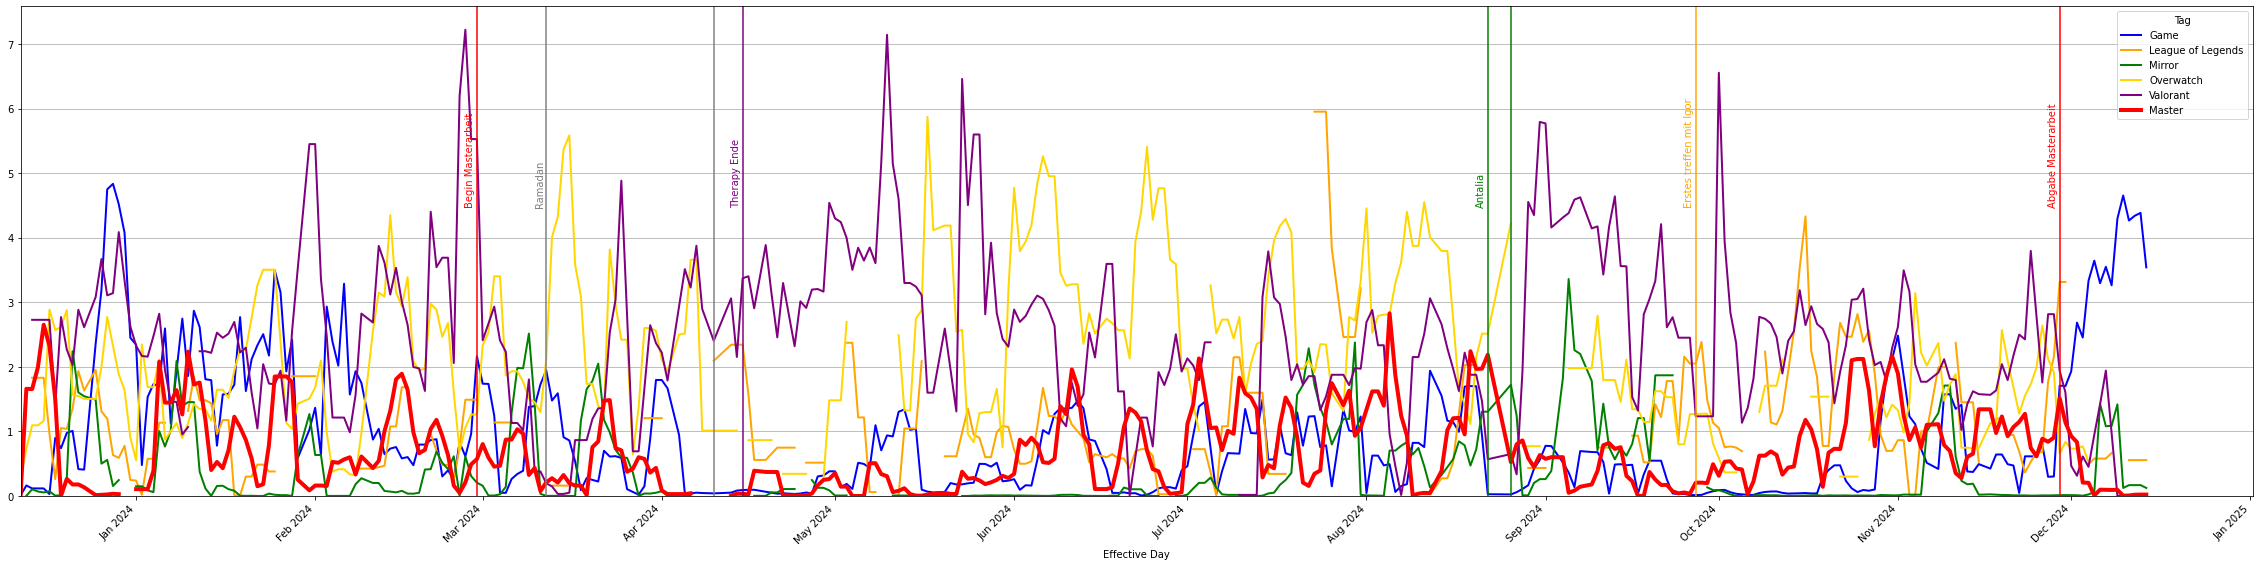

In [ ]:
def all_time_analysis_split_games(self):
  self.import_and_preprocess()

  window_size = 4 # Averaged over how many days?
  hide_lines = ["Other", "Social", "Browser"]
  
  # specific_processes = ["Valorant", "League of Legends", "Overwatch", "csgo", "Steam"]
  specific_processes = ["Valorant", "League of Legends", "Overwatch"]

  app = self.app.copy()
  app["Process"].replace({
    "League of Legends (TM) Client": "League of Legends", 
    "VALORANT-Win64-Shipping": "Valorant",
    "csgo": "CS:GO",
    "Steam Client WebHelper": "Steam"
  }, inplace=True)
  
  print(app.head())

  app.loc[(app['Tag'] == 'Game') & (app['Process'].isin(specific_processes)), 'Tag'] = app.loc[
    (app['Tag'] == 'Game') & (app['Process'].isin(specific_processes)), 'Process']

  app = app[~app['Tag'].isin(hide_lines)]
  app['Duration_in_hours'] = app['Duration'].dt.total_seconds() / 3600

  grouped_data = app.groupby(['Effective_Day', 'Tag'])['Duration_in_hours'].sum().reset_index()
  pivot_data = grouped_data.pivot(index='Effective_Day', columns='Tag', values='Duration_in_hours')
  smoothed_data = pivot_data.rolling(window=window_size, min_periods=1).mean()
  plt.figure(figsize=(40, 10)) 
  # smoothed_data.plot(kind='line', color=self.colors)
  # smoothed_data.plot(kind='line', color=self.colors, linewidth=2.0)
  # smoothed_data.plot(kind='line', linewidth=2.0)
  # for tag in smoothed_data.columns:
  #   if tag == "Master":
  #       smoothed_data[tag].plot(label=tag, linewidth=4.0, color=self.colors.get(tag, "black"))  # Thicker line for "Master"
  #   else:
  #       smoothed_data[tag].plot(label=tag, linewidth=2.0, color=self.colors.get(tag, "black"))  # Default line thickness

  for tag in smoothed_data.columns:
    if tag != "Master":
      smoothed_data[tag].plot(label=tag, linewidth=2.0, color=self.colors.get(tag, "black"))

  # Plot "Master" last to ensure it is on top
  if "Master" in smoothed_data.columns:
    smoothed_data["Master"].plot(label="Master", linewidth=4.0, color=self.colors.get("Master", "red"))


  important_dates = [[DT.date(2024, 2, 29), "Begin Masterarbeit", "red"],
                     [DT.date(2024, 3, 12), "Ramadan", "grey"],
                     [DT.date(2024, 4, 10), "", "grey"],
                     [DT.date(2024, 4, 15), "Therapy Ende", "purple"],
                     [DT.date(2024, 11, 29), "Abgabe Masterarbeit", "red"],
                     [DT.date(2024, 9, 27), "Erstes treffen mit Igor", "orange"],
                     [DT.date(2024, 8, 22), "Antalia", "green"],
                     [DT.date(2024, 8, 26), "", "green"]
                    ]
  for date, name, color in important_dates:
    plt.axvline(x = date, color = color)
    plt.text(date - DT.timedelta(days=2), 4.5 , name, rotation=90, color=color)


  # Set x-axis major ticks to monthly intervals
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year' (e.g., 'Jan 2024')

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45)

  plt.ylim(ymin=0)
  plt.xlim(xmin=app["Effective_Day"].min())

  plt.xlabel('Effective Day')
  plt.legend(title='Tag')
  plt.grid(axis='y')
  
  # Show the plot
  plt.savefig(self.save_path + "/all_time_split_games.jpg")
  plt.show()

TimeManagement.all_time_analysis_split_games = all_time_analysis_split_games
colors = {"Game": "blue", "Mirror":"green", "Master": "red", "Browser": "orange", "Other":"grey", "Social":"purple", "None": "black", 
          "League of Legends": "orange", "Overwatch": "gold", "Valorant": "purple"}
tm = TimeManagement(reloadTime, root_path, save_path, colors, export=False)
tm.all_time_analysis_split_games()

## Google Timeline

In [ ]:
with open("./Timeline.json") as file:
    data = json.load(file)

print(data.keys())

dict_keys(['semanticSegments', 'rawSignals', 'userLocationProfile'])


In [ ]:
timeline = pd.DataFrame(data["semanticSegments"])
timeline.startTime = pd.to_datetime(timeline.startTime)
timeline.endTime = pd.to_datetime(timeline.endTime)

cutoff_date = pd.Timestamp("2023-12-01", tz='Europe/Berlin')
timeline = timeline[timeline['startTime'] > cutoff_date].reset_index(drop=True)

timeline.head(20)

,startTime,endTime,timelinePath,startTimeTimezoneUtcOffsetMinutes,endTimeTimezoneUtcOffsetMinutes,visit,activity,timelineMemory
0,2023-12-01 17:00:00+01:00,2023-12-01 19:00:00+01:00,"[{'point': '52.4494065Â°, 13.3657864Â°', 'time...",NaN,NaN,NaN,NaN,NaN
1,2023-12-01 17:05:49+01:00,2023-12-01 17:06:39+01:00,NaN,60.0,60.0,NaN,"{'start': {'latLng': '52.4484475Â°, 13.3667762...",NaN
2,2023-12-01 17:06:39+01:00,2023-12-01 17:14:08+01:00,NaN,60.0,60.0,"{'hierarchyLevel': 0, 'probability': 0.8500000...",NaN,NaN
3,2023-12-01 17:14:08+01:00,2023-12-01 17:26:37+01:00,NaN,60.0,60.0,NaN,"{'start': {'latLng': '52.4497832Â°, 13.3673986...",NaN
4,2023-12-01 17:26:37+01:00,2023-12-01 17:36:47+01:00,NaN,60.0,60.0,"{'hierarchyLevel': 0, 'probability': 0.9700000...",NaN,NaN
5,2023-12-01 17:36:47+01:00,2023-12-01 17:57:05+01:00,NaN,60.0,60.0,NaN,"{'start': {'latLng': '52.4707715Â°, 13.3849919...",NaN
6,2023-12-01 17:57:05+01:00,2023-12-01 18:05:41+01:00,NaN,60.0,60.0,NaN,"{'start': {'latLng': '52.4352195Â°, 13.5415915...",NaN
7,2023-12-01 18:05:41+01:00,2023-12-02 00:09:49+01:00,NaN,60.0,60.0,"{'hierarchyLevel': 0, 'probability': 0.9300000...",NaN,NaN
8,2023-12-01 21:00:00+01:00,2023-12-01 23:00:00+01:00,"[{'point': '52.4308477Â°, 13.5461514Â°', 'time...",NaN,NaN,NaN,NaN,NaN
9,2023-12-01 23:00:00+01:00,2023-12-02 01:00:00+01:00,"[{'point': '52.430033Â°, 13.5412866Â°', 'time'...",NaN,NaN,NaN,NaN,NaN


In [ ]:
frequentPlaces = data["userLocationProfile"]["frequentPlaces"]

user_spots = {}

for user_spot in frequentPlaces:
  coords = [float(x) for x in user_spot["placeLocation"].replace("Â°", "").split(",")]
  user_spots[user_spot["label"]] = coords

print(user_spots)


{'HOME': [52.447773, 13.3655508], 'WORK': [52.5125322, 13.3269446]}


In [ ]:
spot_timelinePath = []

for i, row in timeline.iterrows():
  grace_radius = 3
  path = []
  
  for spot in row.timelinePath:
    coords = [float(x) for x in spot["point"].replace("Â°", "").split(",")]
    spot_name = "OTHER"
    for user_spots_name, user_spots_coords in user_spots.items():
      dis = distance.distance(coords, user_spots["HOME"])
      if dis < grace_radius:
        spot_name = user_spots_name
        break

    path += [[spot_name, spot["time"]]]
  
  spot_timelinePath += path
  break

pprint(spot_timelinePath)

[['HOME', '2023-12-01T17:07:00.000+01:00'],
 ['HOME', '2023-12-01T17:14:00.000+01:00'],
 ['HOME', '2023-12-01T17:17:00.000+01:00'],
 ['HOME', '2023-12-01T17:20:00.000+01:00'],
 ['HOME', '2023-12-01T17:21:00.000+01:00'],
 ['HOME', '2023-12-01T17:23:00.000+01:00'],
 ['HOME', '2023-12-01T17:27:00.000+01:00'],
 ['HOME', '2023-12-01T17:27:00.000+01:00'],
 ['HOME', '2023-12-01T17:30:00.000+01:00'],
 ['HOME', '2023-12-01T17:32:00.000+01:00'],
 ['HOME', '2023-12-01T17:37:00.000+01:00'],
 ['OTHER', '2023-12-01T17:38:00.000+01:00'],
 ['OTHER', '2023-12-01T17:45:00.000+01:00'],
 ['OTHER', '2023-12-01T17:47:00.000+01:00'],
 ['OTHER', '2023-12-01T17:49:00.000+01:00'],
 ['OTHER', '2023-12-01T17:49:00.000+01:00'],
 ['OTHER', '2023-12-01T17:51:00.000+01:00'],
 ['OTHER', '2023-12-01T17:57:00.000+01:00'],
 ['OTHER', '2023-12-01T17:57:00.000+01:00'],
 ['OTHER', '2023-12-01T18:00:00.000+01:00'],
 ['OTHER', '2023-12-01T18:03:00.000+01:00'],
 ['OTHER', '2023-12-01T18:06:00.000+01:00'],
 ['OTHER', '2023-12-0